<a href="https://colab.research.google.com/github/yupopov/stepik-dl-nlp/blob/master/task1_20newsgroups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тематическая классификация длинных текстов - TFIDF и LogReg

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [ ]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [ ]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [ ]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


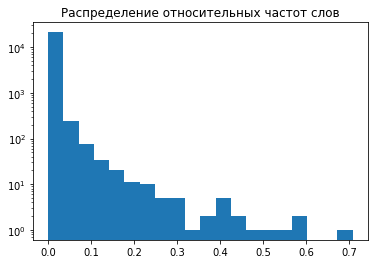

In [ ]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [ ]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


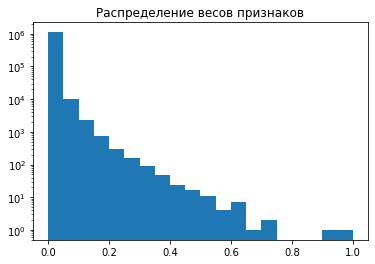

In [ ]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [ ]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


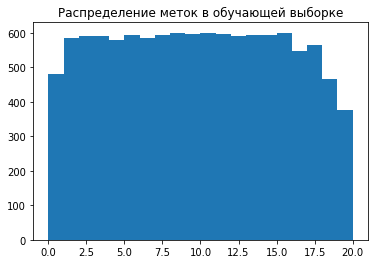

In [ ]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

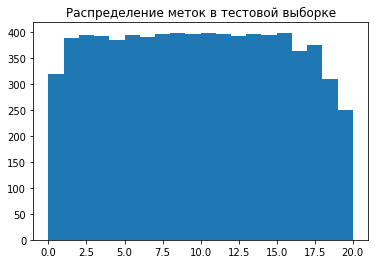

In [ ]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [ ]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [ ]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 2.54 сек
Среднее значение функции потерь на обучении 2.225023294236027
Среднее значение функции потерь на валидации 2.119315680810961
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 2.49 сек
Среднее значение функции потерь на обучении 0.9164805346626347
Среднее значение функции потерь на валидации 1.6757621719675548
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 2.48 сек
Среднее значение функции потерь на обучении 0.4659296732585309
Среднее значение функции потерь на валидации 1.4736619500790613
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 2.51 сек
Среднее значение функции потерь на обучении 0.2840370452925984
Среднее значение функции потерь на валидации 1.345172615627111
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 2.47 сек
Среднее значение функции потерь на обучении 0.19067813285579116
Среднее значение функции потерь на валидации 1.2647146718986964
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 2.52 сек
Среднее значение функции поте

## Оценка качества

In [ ]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:02<00:00, 148.68it/s]
  7%|▋         | 16/235.375 [00:00<00:01, 154.76it/s]

Среднее значение функции потерь на обучении 0.003156960941851139
Доля верных ответов 0.9993812975075128



236it [00:01, 150.81it/s]                             

Среднее значение функции потерь на валидации 0.9307219982147217
Доля верных ответов 0.7651354221986192


# Альтернативная реализация на scikit-learn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [ ]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.495478891857855
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.653902258233705
Доля верных ответов 0.8190387679235263


## Эксперименты с логистической регрессией


Попробуем поэкспериментировать с параметрами и улучшить результат логистической регрессии. Лучший результат получается при использовании лемматизации из nltk и тех значениях гиперпараметров векторизатора и логит регрессии, что указаны ниже, перебор по сетке через ```HalvingGridSearchCV``` дает результат немного похуже. Стандартизация данных и отбор признаков через $L_1$-регрессию не улучшают результат, и вообще от практически стопроцентной accuracy на тренировочном множестве получается избавиться только с аналогичным падением accuracy на тестовом множестве (то есть, неочевидно как избавиться от переобучения). Возможно, имеет смысл вручную настроить гиперпараметры для лемматизации из spaCy. SVM дает аналогичные по качеству результаты.

In [ ]:
import re

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import spacy

TOKEN_RE = re.compile(r'[\w\d]+')
lemmatizer = WordNetLemmatizer()


def tokenize_text_nltk_lemmatizer(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [lemmatizer.lemmatize(token) for token in all_tokens if len(token) >= min_token_size]


nlp = spacy.load('en', disable=['parser', 'ner']) 

def tokenize_text_spacy_lemmatizer(txt, min_token_size=4):
    txt = txt.lower()
    return [token.lemma_ for token in nlp(txt) if len(token) >= min_token_size]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_lemmatized_spacy = list(' '.join([token.lemma_ for token in sent if len(token) >= 4]) for sent in nlp.pipe(train_source['data']))
test_lemmatized_spacy = list(' '.join([token.lemma_ for token in sent if len(token) >= 4]) for sent in nlp.pipe(test_source['data']))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

vectorizer = TfidfVectorizer(tokenizer=tokenize_text_nltk_lemmatizer,
                                stop_words='english',
                                max_features=250000,
                                ngram_range=(1, 2),
                                max_df=0.6,
                                min_df=1,
                                smooth_idf=False,
                                sublinear_tf=True
                                )

scaler = StandardScaler

selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=100))

logit = LogisticRegression(C=1000,
                           solver='liblinear',
                           fit_intercept=False,
                           # class_weight='balanced'
                           max_iter=100,
                           )
svm = LinearSVC(C=100, fit_intercept=False, class_weight='balanced')

sklearn_pipeline = Pipeline((('vect', vectorizer),
                             # ('scaler', scaler),
                             # ('selector', selector),
                             ('cls', logit)))

def evaluate_model(model=sklearn_pipeline,
                   train_set=train_source['data'],
                   train_labels=train_source['target'],
                   test_set=test_source['data'],
                   test_labels=test_source['target']):
  model.fit(train_set, train_labels)

  if hasattr(model, 'predict_proba'):
    train_pred = model.predict_proba(train_set)
  else: # svm
    train_pred = model.decision_function(train_set)
  train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                                                  torch.from_numpy(train_labels))
  print('Среднее значение функции потерь на обучении', float(train_loss))
  print('Доля верных ответов', accuracy_score(train_labels, train_pred.argmax(-1)))
  print()

  if hasattr(model, 'predict_proba'):
    test_pred = model.predict_proba(test_set)
  else: # svm
    test_pred = model.decision_function(test_set)
  test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                                                  torch.from_numpy(test_labels))
  print('Среднее значение функции потерь на валидации', float(test_loss))
  print('Доля верных ответов', accuracy_score(test_labels, test_pred.argmax(-1)))

evaluate_model()

Среднее значение функции потерь на обучении 2.0860611914362086
Доля верных ответов 0.999734841788934

Среднее значение функции потерь на валидации 2.2545607555395586
Доля верных ответов 0.8649761019649496


In [ ]:
params = {'vect__tokenizer': None}
evaluate_model(sklearn_pipeline.set_params(**params),
               train_set=train_lemmatized_spacy,
               test_set=test_lemmatized_spacy)

Среднее значение функции потерь на обучении 2.08541354687641
Доля верных ответов 0.9998232278592893

Среднее значение функции потерь на валидации 2.2583571906521924
Доля верных ответов 0.8559479553903345


## Эксперименты с нейросетью

Нейросеть с одним скрытым слоем на 100 нейронов и активацией ReLU обучается дольше, а результат получается примерно такой же. Добавлять фичи (лучший вариант получается при 100000 фичах) и скрытые нейроны в этом слое уже больше нет смысла, результат только падает. Но поменять learning rate до $10^{-3}$ сильно помогает. Можно добавить еще слой, но лучше получить плотный эмбеддинг и решать эту задачу более подходящими для этого нейронками.

In [ ]:
vectorizer_nn = TfidfVectorizer(tokenizer=tokenize_text_nltk_lemmatizer,
                                stop_words='english',
                                max_features=100000,
                                ngram_range=(1, 2),
                                max_df=0.6,
                                min_df=1,
                                smooth_idf=False,
                                sublinear_tf=True
                                )

train_vectors = vectorizer_nn.fit_transform(train_source['data'])
test_vectors = vectorizer_nn.transform(test_source['data'])

train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

N_HIDDEN_NEURONS = 100
model = nn.Sequential(
                       nn.Linear(len(vectorizer_nn.vocabulary_), N_HIDDEN_NEURONS),
                       nn.ReLU(),
                       nn.Linear(N_HIDDEN_NEURONS, UNIQUE_LABELS_N),
                       )

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-3,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

Эпоха 0
Эпоха: 354 итераций, 10.77 сек
Среднее значение функции потерь на обучении 1.7840214192362156
Среднее значение функции потерь на валидации 0.9341650001578412
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 10.66 сек
Среднее значение функции потерь на обучении 0.2565921945444776
Среднее значение функции потерь на валидации 0.612678829896248
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 10.75 сек
Среднее значение функции потерь на обучении 0.06022554291885788
Среднее значение функции потерь на валидации 0.5509524681305481
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 10.82 сек
Среднее значение функции потерь на обучении 0.02306603196887352
Среднее значение функции потерь на валидации 0.5299046498612833
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 10.86 сек
Среднее значение функции потерь на обучении 0.012853154582418713
Среднее значение функции потерь на валидации 0.5177854694804903
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 10.81 сек
Среднее значение ф

  1%|▏         | 5/353.5625 [00:00<00:08, 42.83it/s]

Среднее значение функции потерь на валидации 0.5151724943701746
Модель не улучшилась за последние 10 эпох, прекращаем обучение


100%|██████████| 354/353.5625 [00:08<00:00, 43.75it/s]
  2%|▏         | 5/235.375 [00:00<00:05, 42.49it/s]

Среднее значение функции потерь на обучении 0.002567702205851674
Доля верных ответов 0.9993812975075128



236it [00:05, 43.11it/s]                             

Среднее значение функции потерь на валидации 0.5011373162269592
Доля верных ответов 0.856744556558683
